EOF
Top-4096,Sketch:8*2048
Execution time:  14.781 seconds.
Top_list with 588200 bytes.
Sketch with 66112 bytes.
Total size 638.9765625 kbytes, 
Precision:  0.584
Find:598
Top_ARE: 4.5778
Top_AAE: 274.4080
Estimate time:  0.717 seconds.


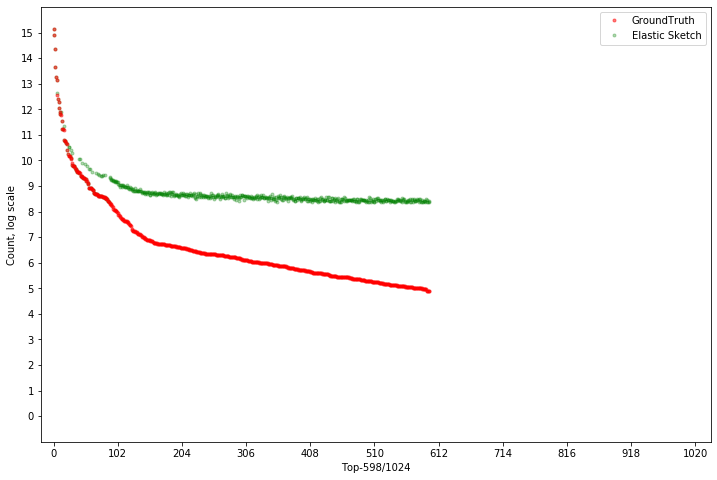

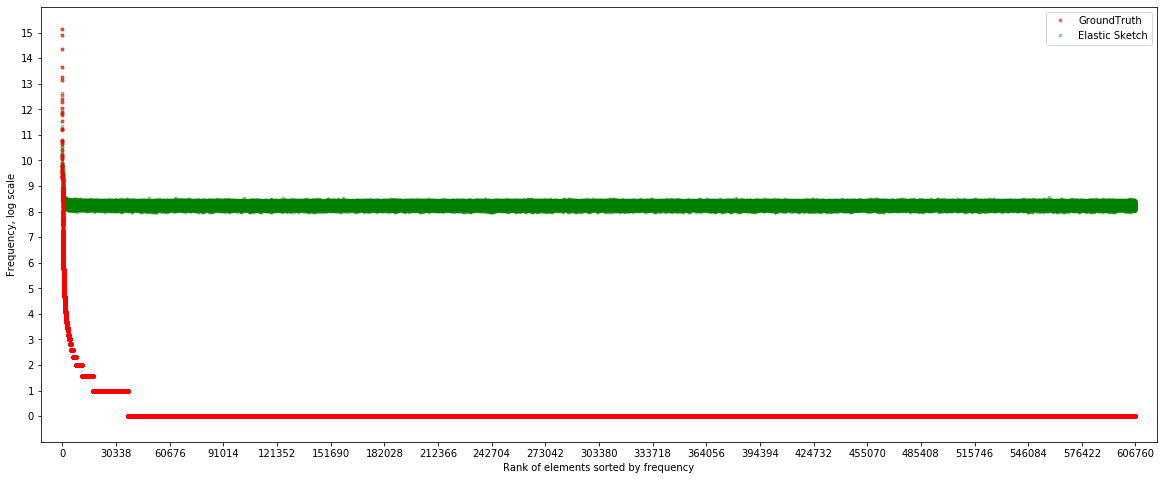

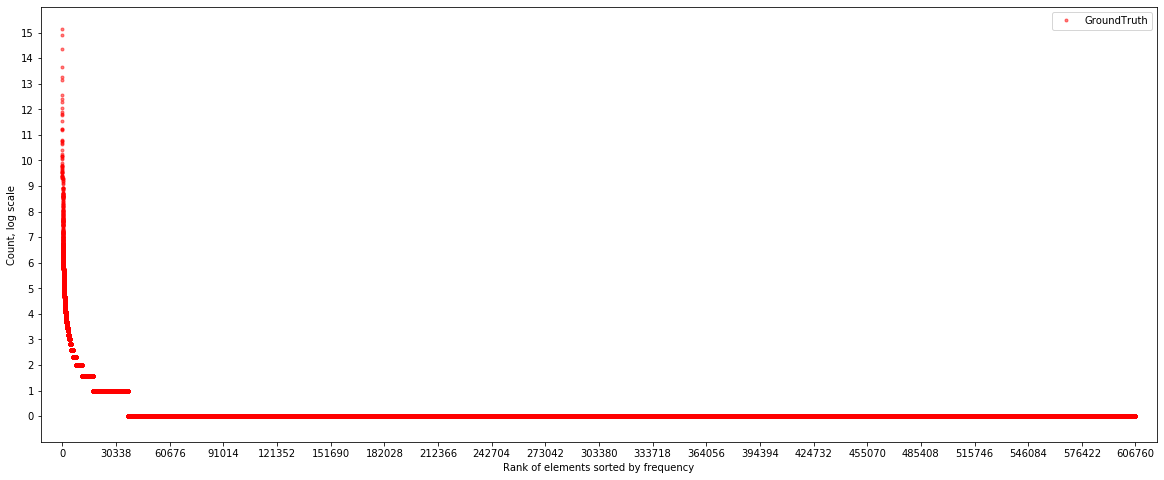

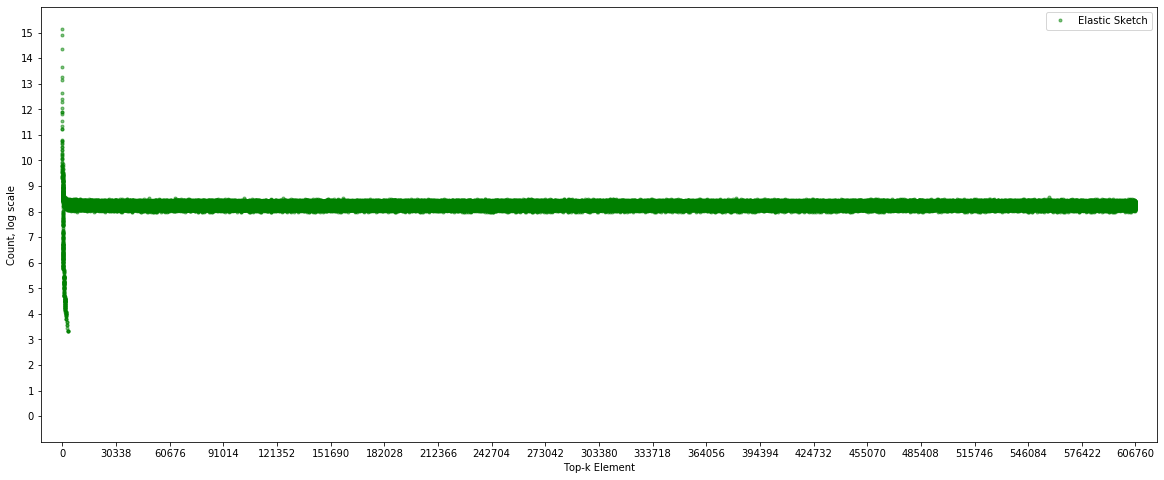

'\nif __name__ == \'__main__\':\n    main()\n\n# result to csv\nimport pandas as pd\ndataset=\'kosarak\'\npath="..\\result\\Ela\\"+dataset+"\\Top_"+str(TC.size)+"_Sk_"+str(TC.depth)+"_"+str(TC.width)\n\n# Top_dict to csv\nfilename=\'Ela_Top_\'+str(size)+\'_kosarak\'+\'.csv\'\ntopdf=pd.DataFrame(Top_dict.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n\n# Sketch to csv\nfilename=\'Ela_Sketch_\'+str(TC.depth)+\'x\'+str(TC.width)+\'_kosarak\'+\'.csv\'\npd.DataFrame(cms.sketch).to_csv((os.path.join(path,filename)))    \n\n'

In [4]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=16
w=2048
d=8
size=4096
topk=1024
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size

# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
    end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision


# Memory usage

id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

#sk0=asizeof.asizeof(Top)
sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))


# Count ARE/AAE in Top

# set True-Positive Top_dict
Top_dict=dict()
for item in Top:
    #item.ID:str
    if item.flag==False:
        Top_dict[item.ID]=item.vote_pos
    else:
        Top_dict[item.ID]=TF.esQuery(item.ID,Top,cms)
    # set comparison , no sort needed
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
tp_set,precision=TF.Get_precision(gr_path,Top_dict,TC.topk)
print("Precision: {:6.3f}".format(precision))

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

# Top-k compare
TF.Plot_topk_compare(gr_path,Top_dict,"Elastic Sketch")

# All element compare
ground_truth=TF.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=TF.esQuery(item,Top,cms)
TF.Plot_all_compare(ground_truth,My_result,"Elastic Sketch")

'''
if __name__ == '__main__':
    main()

# result to csv
import pandas as pd
dataset='kosarak'
path="..\\result\\Ela\\"+dataset+"\\Top_"+str(TC.size)+"_Sk_"+str(TC.depth)+"_"+str(TC.width)

# Top_dict to csv
filename='Ela_Top_'+str(size)+'_kosarak'+'.csv'
topdf=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

# Sketch to csv
filename='Ela_Sketch_'+str(TC.depth)+'x'+str(TC.width)+'_kosarak'+'.csv'
pd.DataFrame(cms.sketch).to_csv((os.path.join(path,filename)))    

'''  

EOF
Top-1536,Sketch:8*1024
Execution time:  14.194 seconds.
Top_list with 220976 bytes.
Sketch with 33344 bytes.
Total size 248.359375 kbytes, 
Find:29
Top_ARE: 0.0653
Top_AAE: 112.1724
Estimate time:  0.656 seconds.

For copy:
Execution time:  14.194 seconds.
Top-57,CMS:8*1024
Top_list with 220976 bytes.
Sketch with 33344 bytes.
Total size 248.359375 kbytes, 
Find 1.000 of Heavy Hitters
Top_ARE: 0.0653
Top_AAE: 112.1724
Estimate time:  0.656 seconds.
seed:[3525404347, 3557607737, 2824547083, 3325777831, 3036296059, 2952339469, 3587270231, 3898582879]


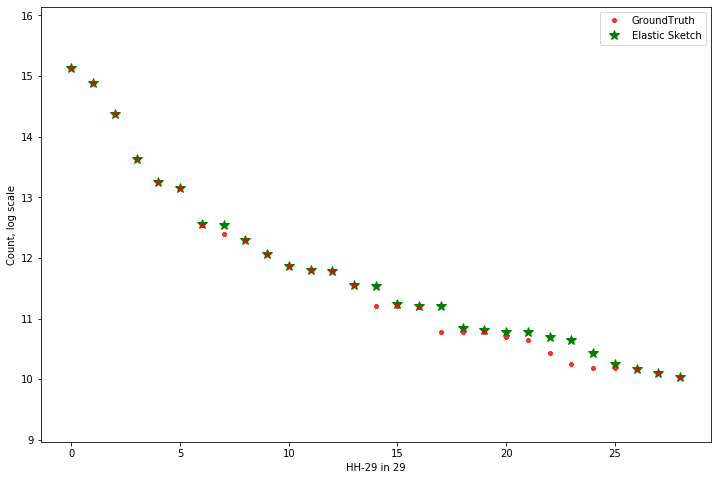

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n\n'

In [6]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='kosarak'
total_count=0
heavy_ratio=1/5000
# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
threshold=8
w=1024
d=8
size=1536
topk=256
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
#item_count=30
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            total_count+=1
            #item_count-=1
            index=TF.positionES(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        #print("update cms: ({},{})".format(Top[index].ID,Top[index].vote_pos))
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
            #print("incoming {},index={}".format(e,index))
            #print(Top)
            #print(cms)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")
'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

'''
